In [1]:
import pandas as pd
import re
import pymorphy2
import nltk

from nltk.corpus import stopwords

In [2]:
import psycopg2

conn = psycopg2.connect("dbname=azs user=postgres password=f8ysz789")
cur = conn.cursor()

df = pd.read_sql_query("SELECT * FROM testing.azs_review limit 10000", conn)

cur.close()
conn.close()

C:\Users\an23m\AppData\Local\Temp\ipykernel_1512\2491829644.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("SELECT * FROM testing.azs_review limit 10000", conn)


In [141]:
df

,object_id,comment_type,comment_time,author_id,profession_level_num,rating,comment_text,likes_num,dislikes_num,date_of_pars,hist_file_load_id
0,1152884364,/ugc/review,2023-11-19 16:14:32.392,2vh5ra4rxv3r400b75duwezbmg,8,5.0,"У Лукойл хорошее топливо. После покупки авто, ...",3,0,2024-09-22 19:11:48+00:00,3
1,1152884364,/ugc/review,2023-11-30 14:21:10.166,2y1wgbnx920rr9ma8q7fr7wv28,24,4.0,Хорошая заправка.,1,1,2024-09-22 19:11:48+00:00,3
2,1152884364,/ugc/review,2023-12-09 02:14:19.434,ywcfqq570ewgmwa831dyr3a4v4,29,5.0,Иногда очень сильно выручает!,4,0,2024-09-22 19:11:48+00:00,3
3,1152884364,/ugc/review,2023-12-10 20:56:15.672,ez6zy75y8r9w3dgrt93uqmhmr0,8,5.0,Проблем с этим местом не было.\nВежливый персо...,1,1,2024-09-22 19:11:48+00:00,3
4,1152884364,/ugc/review,2023-12-11 21:45:16.717,nc41ftezqdcwcxptv1rfpb1k80,9,5.0,Очередей нет. Заправщик всегда на месте. Качес...,3,0,2024-09-22 19:11:48+00:00,3
...,...,...,...,...,...,...,...,...,...,...,...
9995,1199313619,/ugc/review,2023-01-28 15:42:57.157,0g9qcz3xznkxg7exnb1w6f5wy0,10,5.0,"Вкусно и машинам, и людям. Вежливый персонал.",3,0,2024-09-22 19:11:48+00:00,3
9996,1199313619,/ugc/review,2023-02-05 20:48:58.728,ghymf80615u30z31625pe0543g,6,5.0,Всегда здесь останавливаемся и заправляемся,3,0,2024-09-22 19:11:48+00:00,3
9997,1199313619,/ugc/review,2023-02-06 20:47:49.118,vn6t14hqp6yzj7tatu5ampg2pc,20,4.0,Качество бензина очень хорошее обслуживание тоже,2,1,2024-09-22 19:11:48+00:00,3
9998,1199313619,/ugc/review,2023-02-11 19:34:28.049,zp7rkptzkdqp1rzfwt1a1mvchw,12,5.0,Хорошая заправка. Приветливый персонал. Есть к...,3,0,2024-09-22 19:11:48+00:00,3


In [142]:
import re
import nltk
from nltk.corpus import stopwords
import pymystem3
from bs4 import BeautifulSoup
import pyaspeller

# Загрузка данных NLTK
nltk.download('stopwords')

# Инициализация стоп-слов и проверки орфографии
stop_words = set(stopwords.words('russian'))
words_to_remove = {'не', 'всегда', 'лучше', 'никогда', 'хорошо', 'нет'}
for word in words_to_remove:
    stop_words.discard(word)

# Словарь для замены сокращений
abbreviations = {
    "незн": "не знаю", 
    "щас": "сейчас", 
    "чё": "что",
    "спс": "спасибо"
}

def replace_abbreviations(text, abbreviations):
    for abbr, full_form in abbreviations.items():
        text = text.replace(abbr, full_form)
    return text

def lemmatize(text):
    mystem = pymystem3.Mystem()  # Инициализация здесь
    return ''.join(mystem.lemmatize(text)).strip()

def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

def correct_spelling(text):
    checker = pyaspeller.YandexSpeller(lang='ru')  # Инициализация здесь
    errors = checker.spell(text)
    for error in errors: 
        text = text.replace(error['word'], error['s'][0])
    return text

def clean_text(text):
    """Полная предобработка текста"""
    text = remove_html(text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.lower()

    text = replace_abbreviations(text, abbreviations)

    text = correct_spelling(text)

    text = lemmatize(text)

    text = ' '.join(word for word in text.split() if 2 <= len(word) <= 15)

    tokens = [word for word in text.split() if word not in stop_words]
    
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\an23m\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
from concurrent.futures import ThreadPoolExecutor
# Функция для обработки всех текстов с использованием ThreadPoolExecutor
def process_all_texts(texts):
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(executor.map(clean_text, texts))  # Используем map для обработки всех текстов
    return results


# Запуск обработки всех текстов
texts = df['comment_text'].tolist()  # Преобразуем столбец в список
results = process_all_texts(texts)

# Добавление результатов в DataFrame
df_copy = df
df_copy['cleaned_comment'] = results

C:\Users\an23m\AppData\Local\Temp\ipykernel_30288\4141999678.py:35: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


In [145]:
df_copy.to_csv('preproccesed_data.csv')

In [5]:
df = pd.read_csv('preproccesed_data.csv')
df[['comment_text', 'cleaned_comment']].head(30)

,comment_text,cleaned_comment
0,"У Лукойл хорошее топливо. После покупки авто, ...","['лукойл', 'хороший', 'топливо', 'покупка', 'а..."
1,Хорошая заправка.,"['хороший', 'заправка']"
2,Иногда очень сильно выручает!,"['очень', 'сильно', 'выручать']"
3,Проблем с этим местом не было.\nВежливый персо...,"['проблема', 'место', 'не', 'вежливый', 'персо..."
4,Очередей нет. Заправщик всегда на месте. Качес...,"['очередь', 'заправщик', 'всегда', 'место', 'к..."
5,Очень хорошее место положения для АЗС\nТак как...,"['очень', 'хороший', 'местоположение', 'азс', ..."
6,"Хорошая заправка, но цены на порядок выше, чем...","['хороший', 'заправка', 'цена', 'порядок', 'вы..."
7,Нравится,['нравиться']
8,Без карты и компаса попасть на эту заправку не...,"['карта', 'компас', 'попадать', 'заправка', 'н..."
9,Отличная сетевая заправка,"['отличный', 'сетевой', 'заправка']"


In [132]:
import os

# Получаем количество логических процессоров
num_cores = os.cpu_count()
print(f"Количество логических процессоров: {num_cores}")

Количество логических процессоров: 12


### Векторизация

логистическая регрессия + плотные векторные представления слов

bag of words 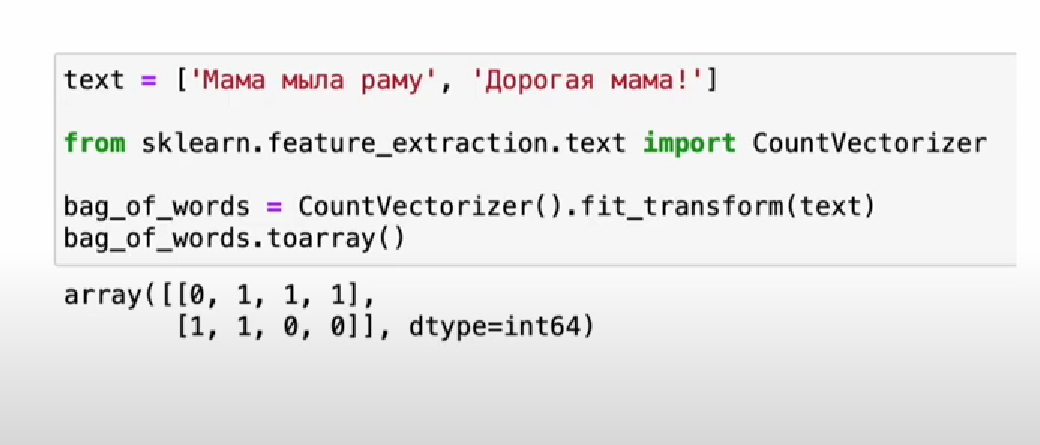

морфологические анализаторы - pymorphy2, pymystem3 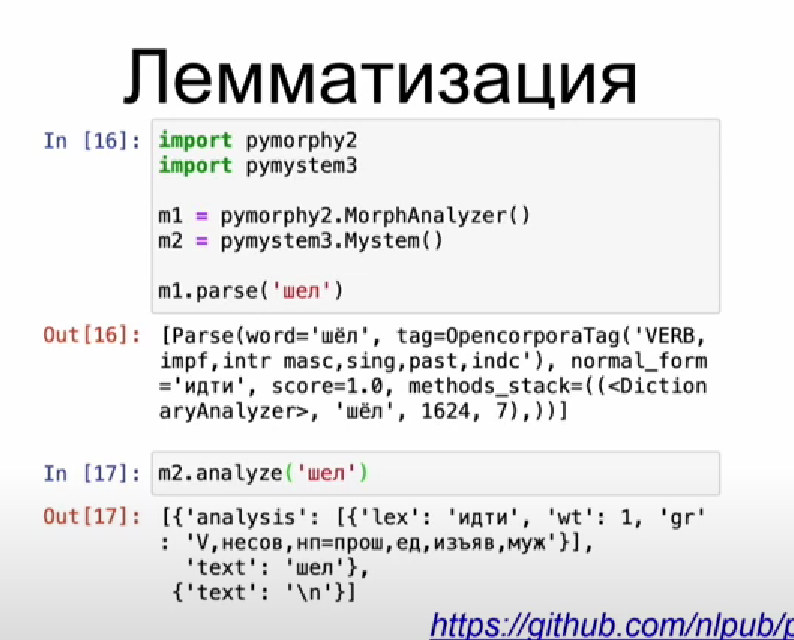

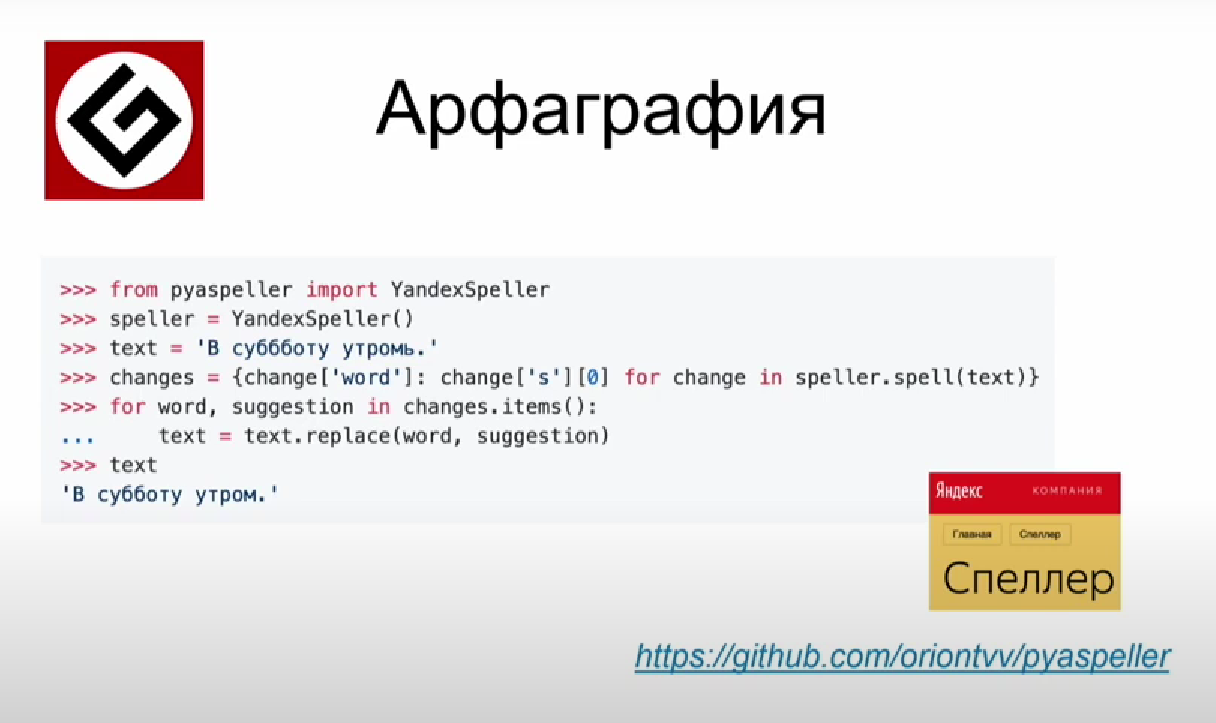

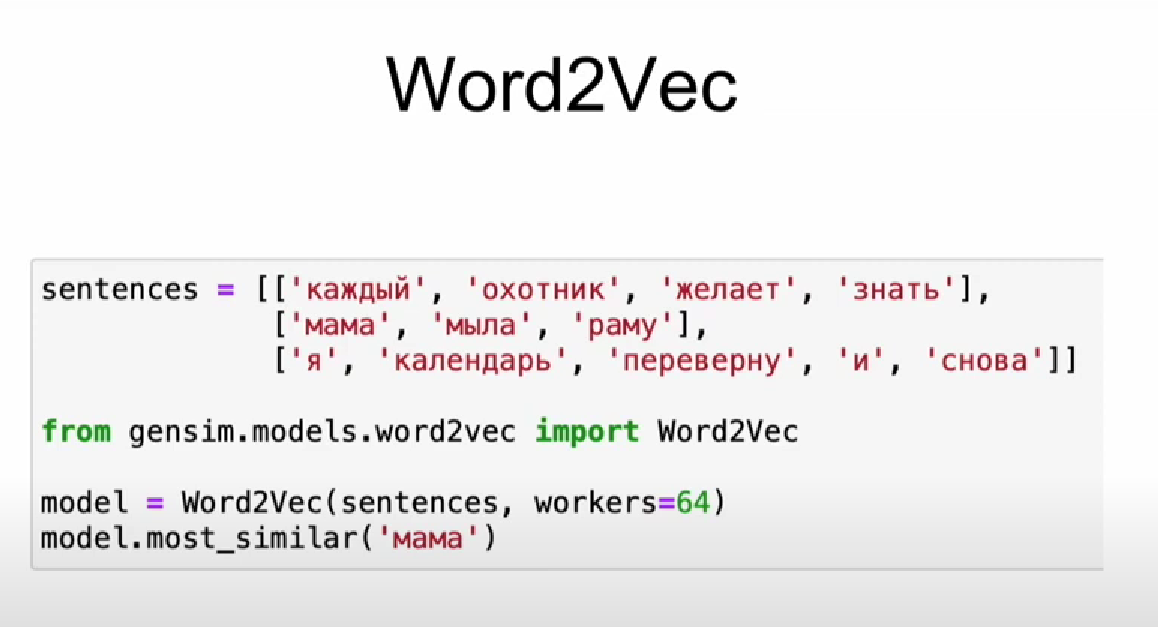 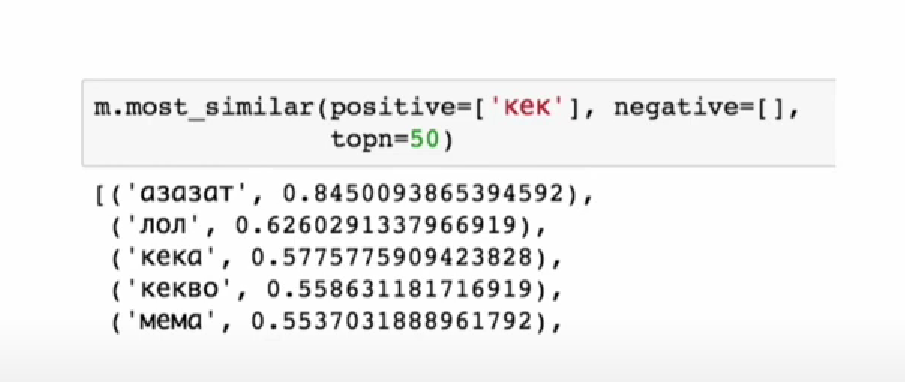

объединение по группам
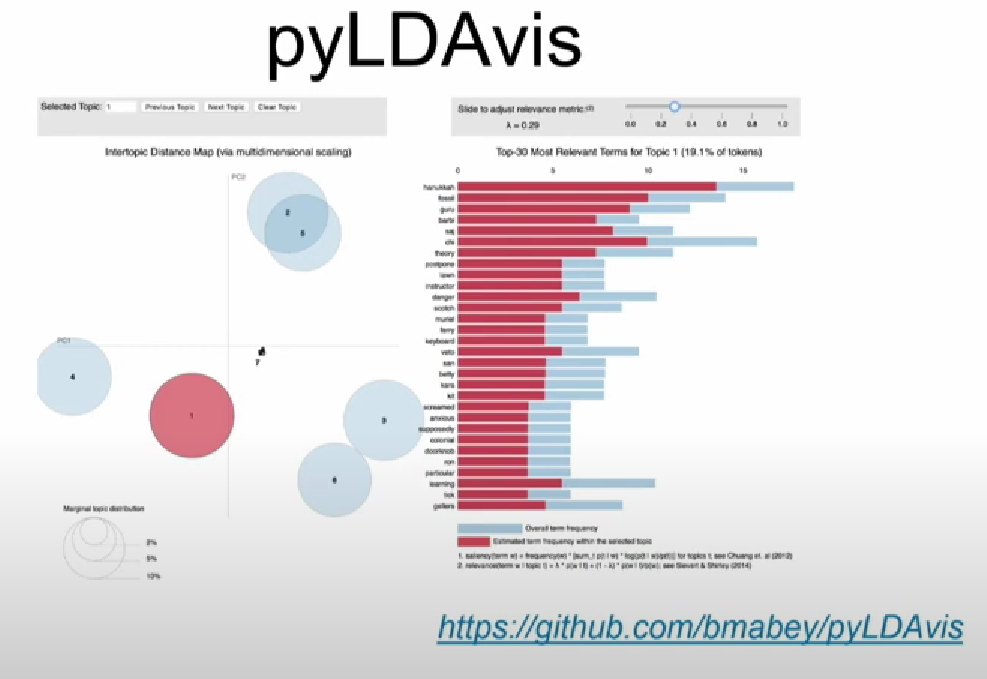
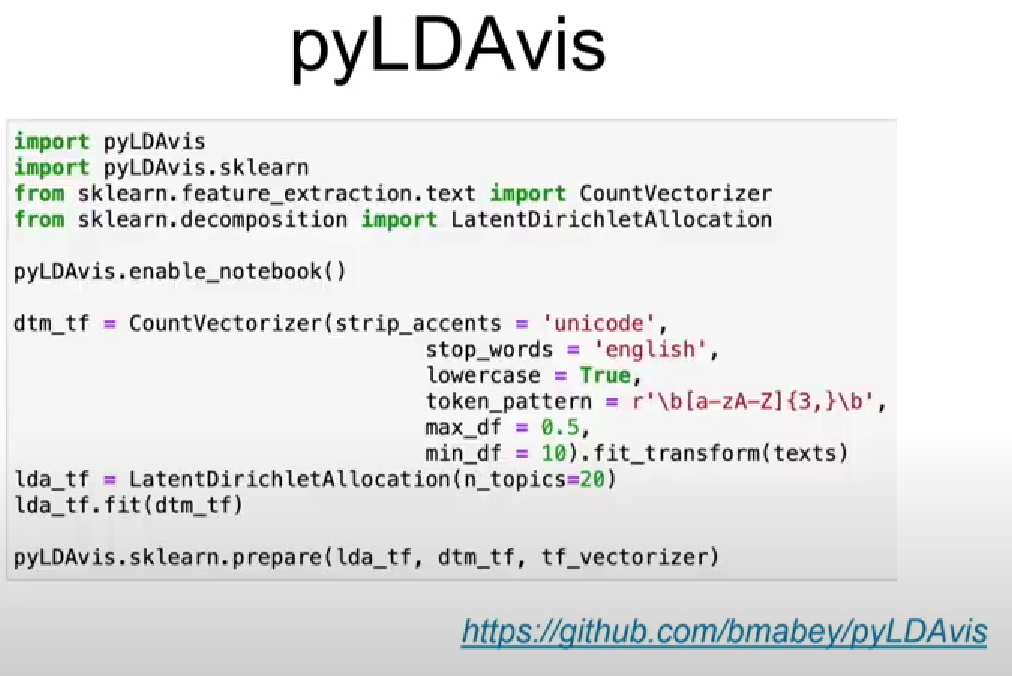